In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from kdg import kdn, kdcnn
from kdg.utils import generate_gaussian_parity, hellinger, plot_2dsim, generate_ood_samples, sample_unifrom_circle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from joblib import Parallel, delayed
from scipy.io import savemat, loadmat
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import activations

### Visualize the data

<AxesSubplot: >

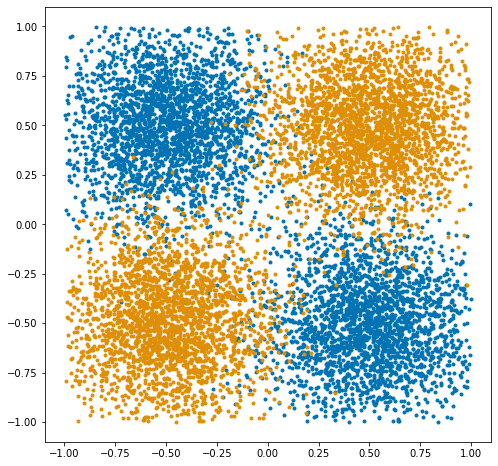

In [2]:
X, y = generate_gaussian_parity(10000)
plot_2dsim(X, y)

In [3]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 64,
        "verbose": False,
        "callbacks": [callback],
    }

In [4]:
# network architecture [10, 10, 10, 10, 2]
def getNN(input_size, num_classes):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(1000, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [5]:
# train Vanilla NN
nn = getNN(input_size=2, num_classes=2)
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)

2023-02-20 10:22:13.305488: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 10:22:13.306144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 10:22:13.490554: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Metal device set to: Apple M1 Max


2023-02-20 10:22:13.695020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping


### Calculate posteriors and likelihoods using KDN

In [6]:
df = {}
model_kdn = kdn(k=.1, network=nn)
model_kdn.fit(X, y, epsilon=1e-4)

#define grids
p = np.arange(-3, 3, step=0.01)
q = np.arange(-3, 3, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_nn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)

posterior_nn = posterior_nn[:,0].reshape(600,600)
posterior_kdn = posterior_kdn[:,0].reshape(600,600)
class1_likelihoods = likelihoods_kdn[:,0].reshape(600,600)
class2_likelihoods = likelihoods_kdn[:,1].reshape(600,600)

df['posterior_dn'] = posterior_nn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1'] = class1_likelihoods
df['likelihood_class2'] = class2_likelihoods

   84/11250 [..............................] - ETA: 20s

2023-02-20 10:31:17.554797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11250/11250 [==============================] - 21s 2ms/step


In [7]:
# get true posterior
tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
proba_true = 0.5*np.ones((600, 600))
tmp = np.array([tp_df["posterior"][x] for x in range(40000)])
tmp = np.flip(tmp.reshape(200, 200), axis=1)
proba_true[200:400, 200:400] = 1 - tmp
#df["true_proba"] = proba_true

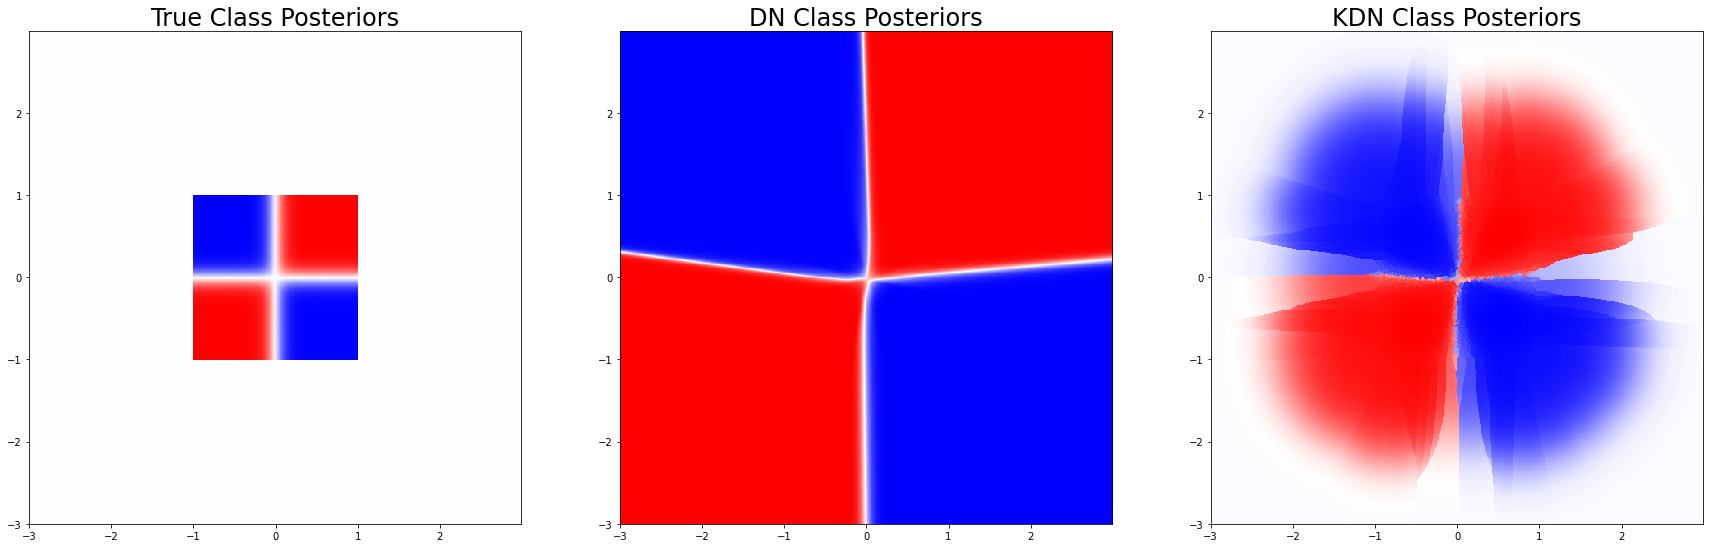

In [8]:
fig1, ax = plt.subplots(1, 3, figsize=(30, 90))

ax0 = ax[0].imshow(
    proba_true,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Class Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    posterior_nn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("DN Class Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    posterior_kdn,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDN Class Posteriors", fontsize=24)
ax[2].set_aspect("equal")
plt.show()

### Visualize class likelihoods

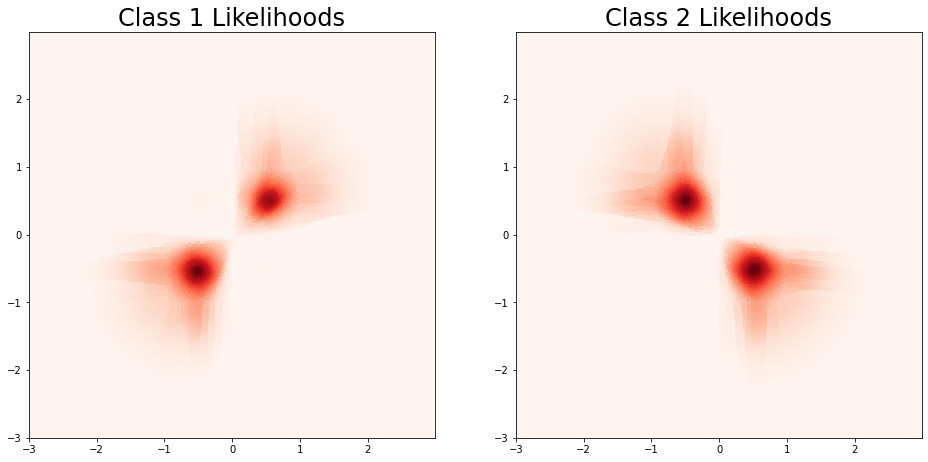

In [9]:
fig1, ax = plt.subplots(1, 2, figsize=(16, 8))

class1_likelihoods /= np.max(np.max(class1_likelihoods))
class2_likelihoods /= np.max(np.max(class2_likelihoods))

ax0 = ax[0].imshow(
    class1_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("Class 1 Likelihoods", fontsize=24)
ax[0].set_aspect("equal")


ax1 = ax[1].imshow(
    class2_likelihoods,
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="Reds",
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("Class 2 Likelihoods", fontsize=24)
ax[1].set_aspect("equal")

### Experiment with misclassification error and hellinger distance

In [27]:
mc_reps = 10
sample_size = [50, 100, 500, 1000, 5000, 10000]
n_test = 1000

tp_df = pd.read_csv("../true_posterior/Gaussian_xor_pdf.csv")
true_posterior = tp_df['posterior']
true_posterior = np.vstack((1-true_posterior.ravel(), true_posterior.ravel())).T
        
    
def experiment_in(sample, n_test, true_posterior):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)
    
    p = np.arange(-1, 1, step=0.01)
    q = np.arange(-1, 1, step=0.01)
    xx, yy = np.meshgrid(p, q)

    grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)

    error_kdn = 1 - np.mean(model_kdn.predict(X_test)==y_test)   
    error_dn = 1 - np.mean(np.argmax(
        model_kdn.network.predict(X_test), axis=1
    )==y_test)
    proba_kdn = model_kdn.predict_proba(grid_samples)
    proba_dn = model_kdn.network.predict(grid_samples)
    hellinger_dis_kdn = hellinger(1-true_posterior, proba_kdn)
    hellinger_dis_dn = hellinger(1-true_posterior, proba_dn)
    mmcIn_dn = np.mean(np.max(proba_dn, axis=1)) 
    mmcIn_kdn = np.mean(np.max(proba_kdn, axis=1))
    
    return error_kdn, error_dn, hellinger_dis_kdn, hellinger_dis_dn, mmcIn_kdn, mmcIn_dn

def experiment_out(in_sample, r, n_test):
    X, y = generate_gaussian_parity(in_sample)
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    X_ood = sample_unifrom_circle(n=n_test, r=r)
    mmcOut_dn = np.mean(np.max(
        model_kdn.network.predict(X_ood), axis=1
        )
    )
    mmcOut_kdn = np.mean(np.max(model_kdn.predict_proba(X_ood), axis=1))
    
    return mmcOut_kdn, mmcOut_dn
        
    
error_kdn_med = []
error_kdn_25 = []
error_kdn_75 = []
error_dn_med = []
error_dn_25 = []
error_dn_75 = []

hellinger_kdn_med = []
hellinger_kdn_25 = []
hellinger_kdn_75 = []
hellinger_dn_med = []
hellinger_dn_25 = []
hellinger_dn_75 = []

mmcIn_kdn_med = []
mmcIn_kdn_25 = []
mmcIn_kdn_75 = []
mmcIn_dn_med = []
mmcIn_dn_25 = []
mmcIn_dn_75 = []

mmcOut_kdn_med = []
mmcOut_kdn_25 = []
mmcOut_kdn_75 = []
mmcOut_dn_med = []
mmcOut_dn_25 = []
mmcOut_dn_75 = []

#### do out-of-distribution results ####
for r in np.arange(0,10.5,.5):
    mmcOut_kdn = []
    mmcOut_dn = []
    res = Parallel(n_jobs=-1)(
            delayed(experiment_out)(
                    1000,
                    r,
                    n_test
                    ) for _ in range(mc_reps)
                )
    
    for ii in range(mc_reps):
        mmcOut_kdn.append(res[ii][0])
        mmcOut_dn.append(res[ii][1])
    
    
    mmcOut_kdn_med.append(
        np.median(mmcOut_kdn)
    )
    mmcOut_kdn_25.append(
        np.quantile(mmcOut_kdn, [0.25])[0]
    )
    mmcOut_kdn_75.append(
        np.quantile(mmcOut_kdn, [0.75])[0]
    )
    
    mmcOut_dn_med.append(
        np.median(mmcOut_dn)
    )
    mmcOut_dn_25.append(
        np.quantile(mmcOut_dn, [0.25])[0]
    )
    mmcOut_dn_75.append(
        np.quantile(mmcOut_dn, [0.75])[0]
    )
    
    
#### do in-distribution results ####
for sample in sample_size:
    res = Parallel(n_jobs=-1)(
            delayed(experiment_in)(
                    sample,
                    n_test,
                    true_posterior
                    ) for _ in range(mc_reps)
                )

    
    err_kdn = []
    err_dn = []
    hellinger_kdn = []
    hellinger_dn = []
    mmcIn_kdn = []
    mmcIn_dn = []
    for ii in range(mc_reps):
        err_kdn.append(res[ii][0])
        err_dn.append(res[ii][1])
        hellinger_kdn.append(res[ii][2])
        hellinger_dn.append(res[ii][3])
        mmcIn_kdn.append(res[ii][4])
        mmcIn_dn.append(res[ii][5])

    error_kdn_med.append(
        np.median(err_kdn)
    )
    error_kdn_25.append(
        np.quantile(err_kdn, [0.25])[0]
    )
    error_kdn_75.append(
        np.quantile(err_kdn, [0.75])[0]
    )

    error_dn_med.append(
        np.median(err_dn)
    )
    error_dn_25.append(
        np.quantile(err_dn, [0.25])[0]
    )
    error_dn_75.append(
        np.quantile(err_dn, [0.75])[0]
    )
    
    hellinger_kdn_med.append(
        np.median(hellinger_kdn)
    )
    hellinger_kdn_25.append(
        np.quantile(hellinger_kdn, [0.25])[0]
    )
    hellinger_kdn_75.append(
        np.quantile(hellinger_kdn, [0.75])[0]
    )

    hellinger_dn_med.append(
        np.median(hellinger_dn)
    )
    hellinger_dn_25.append(
        np.quantile(hellinger_dn, [0.25])[0]
    )
    hellinger_dn_75.append(
        np.quantile(hellinger_dn, [0.75])[0]
    )

    mmcIn_kdn_med.append(
        np.median(mmcIn_kdn)
    )
    mmcIn_kdn_25.append(
        np.quantile(mmcIn_kdn, [0.25])[0]
    )
    mmcIn_kdn_75.append(
        np.quantile(mmcIn_kdn, [0.75])[0]
    )

    mmcIn_dn_med.append(
        np.median(mmcIn_dn)
    )
    mmcIn_dn_25.append(
        np.quantile(mmcIn_dn, [0.25])[0]
    )
    mmcIn_dn_75.append(
        np.quantile(mmcIn_dn, [0.75])[0]
    )


df['error_kdn_med'] = error_kdn_med
df['error_kdn_25'] = error_kdn_25
df['error_kdn_75'] = error_kdn_75

df['error_dn_med'] = error_dn_med
df['error_dn_25'] = error_dn_25
df['error_dn_75'] = error_dn_75

df['hellinger_kdn_med'] = hellinger_kdn_med
df['hellinger_kdn_25'] = hellinger_kdn_25
df['hellinger_kdn_75'] = hellinger_kdn_75

df['hellinger_dn_med'] = hellinger_dn_med
df['hellinger_dn_25'] = hellinger_dn_25
df['hellinger_dn_75'] = hellinger_dn_75

df['mmcIn_kdn_med'] = mmcIn_kdn_med
df['mmcIn_kdn_25'] = mmcIn_kdn_25
df['mmcIn_kdn_75'] = mmcIn_kdn_75

df['mmcIn_dn_med'] = mmcIn_dn_med
df['mmcIn_dn_25'] = mmcIn_dn_25
df['mmcIn_dn_75'] = mmcIn_dn_75

df['mmcOut_kdn_med'] = mmcOut_kdn_med
df['mmcOut_kdn_25'] = mmcOut_kdn_25
df['mmcOut_kdn_75'] = mmcOut_kdn_75

df['mmcOut_dn_med'] = mmcOut_dn_med
df['mmcOut_dn_25'] = mmcOut_dn_25
df['mmcOut_dn_75'] = mmcOut_dn_75

INFO:tensorflow:Assets written to: ram://28f4b367-ba4c-4fd6-b3d2-e7329d3b757f/assets
INFO:tensorflow:Assets written to: ram://abef5ba5-014b-4d51-93a1-70a966dc083c/assets
INFO:tensorflow:Assets written to: ram://f04faff6-50a4-4d30-a9fc-ce5c826c6663/assets
INFO:tensorflow:Assets written to: ram://c5926ef7-2bb4-449b-b224-16060bb25070/assets
INFO:tensorflow:Assets written to: ram://a6d42376-154a-417d-8e1a-be9254357de9/assets
INFO:tensorflow:Assets written to: ram://274b6fd5-eed0-4afc-a388-272310406bf3/assets
INFO:tensorflow:Assets written to: ram://ab2a9e4f-e9f7-4e05-94c6-20618b266405/assets
Metal device set to: Apple M1 Max
Metal device set to: Apple M1 Max


2023-02-20 19:51:01.244397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 19:51:01.244576: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 19:51:01.244397: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 19:51:01.244821: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL,

Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://c9d8d430-7160-43d6-a8df-c218eda39ff9/assets


2023-02-20 19:51:01.459568: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 19:51:01.459692: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 19:51:01.731353: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 19:51:01.733826: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 19:51:01.993175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:02.032786: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Fai

Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://14a2176e-755a-43f9-bf84-def0110159dd/assets


2023-02-20 19:51:02.285889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:02.760469: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 19:51:02.906302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 19:51:02.906512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max
INFO:tensorflow:Assets written to: ram://45f59ecd-97d8-4ef7-9e71-20a68e6fafc7/assets


2023-02-20 19:51:03.030537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:03.610399: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 19:51:03.643710: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 19:51:03.645000: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


2023-02-20 19:51:03.852061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:04.226636: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 19:51:04.292008: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 19:51:04.292157: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


2023-02-20 19:51:04.511921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:05.111657: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 19:51:05.113691: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 19:51:05.113829: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


2023-02-20 19:51:05.413054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Metal device set to: Apple M1 Max


2023-02-20 19:51:05.954034: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-20 19:51:05.954186: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-02-20 19:51:05.966925: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 19:51:06.406490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:07.371805: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 19:51:07.408174: I tensorflow/core/common_runtime/pluggable_device/pluggable_de

Metal device set to: Apple M1 Max
Epoch 26: early stopping


2023-02-20 19:51:07.879685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:08.801199: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-20 19:51:09.140987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
Epoch 40: early stopping
Epoch 39: early stopping
Epoch 56: early stopping
Epoch 62: early stopping


2023-02-20 19:51:19.096542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-20 19:51:21.332291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 84: early stopping


2023-02-20 19:51:22.109902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:22.202753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 19:51:22.674010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 91: early stopping


2023-02-20 19:51:26.290987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 100: early stopping


2023-02-20 19:51:28.477413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:51:30.948294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 183: early stopping


2023-02-20 19:51:32.939430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:51:37.922875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://1d259ec9-fd29-4d31-b718-a62a340729d1/assets
INFO:tensorflow:Assets written to: ram://f433d65c-d677-4c67-8161-3ac6959f95de/assets


2023-02-20 19:51:39.065538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:39.602106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0d4af01d-3526-4766-b165-f284c325a51c/assets
INFO:tensorflow:Assets written to: ram://196b9b4c-c41b-4607-9030-de3e2aaf2e8d/assets


2023-02-20 19:51:40.315378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://11d08450-c4c7-4587-83f3-91e4a2e1fdd5/assets


2023-02-20 19:51:40.888286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1dd0559e-5850-4875-b7d1-f42f2847c6f8/assets


2023-02-20 19:51:41.518598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:51:42.269513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://542b018b-5dcd-4b79-99a3-9c6247ba3623/assets


2023-02-20 19:51:43.201775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://be02a3c8-d19a-49fe-b393-de7cbe146ac8/assets
Epoch 32: early stopping


2023-02-20 19:51:44.262976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6dee32b3-cc0a-4b17-ab0d-0cf4d4d9475e/assets


2023-02-20 19:51:45.291312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3734e147-a558-4420-8e43-03d572414b96/assets


2023-02-20 19:51:46.495504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 59: early stopping
Epoch 66: early stopping
Epoch 53: early stopping
Epoch 51: early stopping
Epoch 42: early stopping


2023-02-20 19:51:56.009562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 95: early stopping
Epoch 68: early stopping


2023-02-20 19:52:01.354084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:52:01.528691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 107: early stopping


2023-02-20 19:52:01.591931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 19:52:02.475100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:52:02.744311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:52:04.412617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:52:05.499660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:52:07.878008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:52:08.059198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://e5bb831a-2840-40a4-9e30-2cd60a11e58e/assets
INFO:tensorflow:Assets written to: ram://23709c5d-cfd4-423d-8f77-137ea3958580/assets


2023-02-20 19:52:09.186813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://04a8a6e0-5942-4a5d-903a-07065c3a526e/assets


2023-02-20 19:52:09.869505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d3d20297-b182-4fd0-95f8-dd0dc38bb957/assets


2023-02-20 19:52:10.441465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c69cfe7b-d987-4727-b82a-654045308de6/assets


2023-02-20 19:52:11.024966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0748d71e-d01a-4871-b364-1b45c959b551/assets


2023-02-20 19:52:11.673453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 20: early stopping


2023-02-20 19:52:12.320292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://fdf1f49e-70e0-409a-8e57-0c3c4e7a4b0c/assets


2023-02-20 19:52:13.187466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://316aaf25-81ca-471a-aa89-f1efed5beb98/assets


2023-02-20 19:52:14.268299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e8421a94-e10b-4cbe-944f-d0f42bb87408/assets


2023-02-20 19:52:15.350768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://8714e575-baf5-4aa5-9618-0ac9b7823a07/assets


2023-02-20 19:52:17.431119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 61: early stopping


2023-02-20 19:52:23.939966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 17ms/step
Epoch 44: early stopping
Epoch 66: early stopping
Epoch 75: early stopping
Epoch 52: early stopping
Epoch 89: early stopping
Epoch 94: early stopping


2023-02-20 19:52:31.645283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 123: early stopping
32/32 [==============================] - 0s 5ms/step


2023-02-20 19:52:33.124511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:52:34.722807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:52:35.250531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:52:35.255574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 134: early stopping


2023-02-20 19:52:35.964773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:52:37.353373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:52:39.901061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:52:42.098323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://9b3164d1-179b-437e-a973-4202ec6c8458/assets
INFO:tensorflow:Assets written to: ram://b9760eb7-02e1-40a1-9c74-e1c87e50d669/assets


2023-02-20 19:52:43.211034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4b64b3b9-701c-4e55-9913-6891707adbc3/assets


2023-02-20 19:52:43.709074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f9b6f6a9-6b96-433d-980c-27dc4c1d219f/assets


2023-02-20 19:52:44.291845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cdd39093-b7f4-421a-aea6-4bb9b6d9124d/assets


2023-02-20 19:52:44.879851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3a8db9a1-a67a-46a5-85cb-b100dfd839c9/assets


2023-02-20 19:52:45.474035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:52:46.235816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 22: early stopping
INFO:tensorflow:Assets written to: ram://c654dc33-81ba-4264-ae56-e382b215f0dd/assets


2023-02-20 19:52:47.118181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://85ffe195-d916-4442-8140-8cd69e324652/assets
INFO:tensorflow:Assets written to: ram://21b7233e-f4dc-475c-9ca2-18f1b159e9b1/assets


2023-02-20 19:52:48.670485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6bc4c661-6e0f-4798-a87e-6acf5d302cb4/assets


2023-02-20 19:52:49.696141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping


2023-02-20 19:52:50.805457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
Epoch 25: early stopping
Epoch 59: early stopping
Epoch 48: early stopping


2023-02-20 19:52:56.719566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 40: early stopping
Epoch 67: early stopping


2023-02-20 19:52:59.875220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 19:53:00.919222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:53:01.962958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:53:03.141448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:53:03.656897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:53:04.846803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:53:04.985006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 88: early stopping
Epoch 123: early stopping


2023-02-20 19:53:11.895600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:53:12.983490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://d077e719-d590-40c2-b4d4-dd73ed04a4fd/assets
INFO:tensorflow:Assets written to: ram://fd420548-64c6-454e-a49a-33fa9c919fe3/assets


2023-02-20 19:53:14.092065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1b2108dd-46ae-4b4a-9cf2-2e7d9163f620/assets


2023-02-20 19:53:14.619573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ef10a84e-2f9b-454e-89f6-4f8830177f6c/assets


2023-02-20 19:53:15.176010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://252dadf8-9cc2-42f9-b06f-303ad73c2211/assets


2023-02-20 19:53:15.765231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:53:16.398756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0d303ba4-01fa-4fe6-85f6-01317a23748a/assets


2023-02-20 19:53:17.442384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cedac1dd-0fc0-46cc-a4a9-9722251668e8/assets


2023-02-20 19:53:18.385774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e069678d-66dd-476e-9f49-97644b441722/assets
INFO:tensorflow:Assets written to: ram://df75e4be-2ed8-452e-8245-650a74250c9f/assets


2023-02-20 19:53:19.745070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://dc0f99ea-0660-4c40-888c-b5fe2affc172/assets


2023-02-20 19:53:21.075311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:53:22.420977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
Epoch 67: early stopping
Epoch 66: early stopping
Epoch 35: early stopping
Epoch 99: early stopping


2023-02-20 19:53:37.553283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-20 19:53:38.171378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 113: early stopping


2023-02-20 19:53:38.832291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:53:39.241826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 89: early stopping


2023-02-20 19:53:41.930327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:53:45.089595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:53:45.681898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:53:45.920807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:53:46.942808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 174: early stopping


2023-02-20 19:53:55.575506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://b16bc42e-8b19-4431-aa38-b7fadb64f348/assets
INFO:tensorflow:Assets written to: ram://9a9598ad-492f-479b-bc17-27a90e348219/assets


2023-02-20 19:53:56.689398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2c4fa1cc-6477-41ab-a90e-a59f86587230/assets


2023-02-20 19:53:57.225958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:53:57.775079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://051e1977-aa2c-415a-8d1b-c9598260ee67/assets
INFO:tensorflow:Assets written to: ram://98d9697b-6c4c-4e27-bd28-03e2379bed6c/assets


2023-02-20 19:53:58.533812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://dc134944-01bc-4c23-985f-1b2c674b1070/assets


2023-02-20 19:53:59.181333: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:53:59.937272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ad470a74-7ff1-43bf-9229-c52420848da8/assets


2023-02-20 19:54:00.909900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://59a6868a-123f-4ec1-85ed-b2103bc6879f/assets
INFO:tensorflow:Assets written to: ram://070ce110-61fc-47a7-bf5f-4a15817dc548/assets


2023-02-20 19:54:02.333440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c24e5fd6-9f68-42b9-9853-c7d647956c37/assets
Epoch 43: early stopping


2023-02-20 19:54:03.725133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:54:04.384716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 40: early stopping
Epoch 40: early stopping
Epoch 94: early stopping


2023-02-20 19:54:15.935892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 13ms/step


2023-02-20 19:54:17.585764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step
Epoch 67: early stopping
Epoch 92: early stopping
Epoch 122: early stopping


2023-02-20 19:54:20.695186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:54:23.086734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:54:24.777525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:54:25.099633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 146: early stopping


2023-02-20 19:54:26.059146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:54:27.103774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:54:29.607195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:54:31.767512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://fbec29e1-ba50-4b39-8035-2b37e528f413/assets
INFO:tensorflow:Assets written to: ram://ef0e17da-fcbd-49e7-ac62-4d9be857856a/assets


2023-02-20 19:54:32.861698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:54:33.386979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5615856b-140c-498d-b5e8-ec05b46fcfdf/assets
INFO:tensorflow:Assets written to: ram://98d2353b-3471-4d28-bb5a-7d37f44adea3/assets


2023-02-20 19:54:34.117957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cf19ea29-3c92-4045-9daa-860055bedb0c/assets


2023-02-20 19:54:34.664962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a22adae4-2fdb-4325-9fcf-6ee6765971d3/assets


2023-02-20 19:54:35.287280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:54:36.051818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1e3c8f0e-e616-43af-a6e0-9731c245900f/assets
Epoch 27: early stopping


2023-02-20 19:54:37.025327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1f710e58-bf11-4d65-9556-2356009b8ace/assets
INFO:tensorflow:Assets written to: ram://eaaa5a94-a2d2-4871-9a2b-9bf3e6654b31/assets


2023-02-20 19:54:38.281690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c82add43-92f4-49b3-9a4e-34f3a79b70f3/assets


2023-02-20 19:54:39.374252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:54:40.248950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
Epoch 48: early stopping
Epoch 60: early stopping


2023-02-20 19:54:47.960003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 78: early stopping
Epoch 72: early stopping


2023-02-20 19:54:51.477141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-20 19:54:52.628449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 19:54:53.584142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 81: early stopping
Epoch 100: early stopping


2023-02-20 19:54:57.539739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 128: early stopping


2023-02-20 19:54:58.228485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:55:01.771391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 147: early stopping


2023-02-20 19:55:03.700817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:55:04.128328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:55:08.448878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://ebd923e1-2f99-4f7a-8570-4e18b4ebd8d4/assets
INFO:tensorflow:Assets written to: ram://5525139a-3f90-4df5-836a-d428cc26eca6/assets


2023-02-20 19:55:09.688762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9baff367-7879-458b-9cfd-e69c588fc46b/assets


2023-02-20 19:55:10.203705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9e243b6a-dd60-4425-b737-04a66039415e/assets


2023-02-20 19:55:10.773660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b86784a0-2faa-4f1a-96a1-d71f5d79b560/assets


2023-02-20 19:55:11.313580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:55:11.919760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0547109f-b3ff-4f75-a396-cb8ce05fe1d7/assets
INFO:tensorflow:Assets written to: ram://0c4bff51-1328-4a29-ab23-4d22f3f756b6/assets


2023-02-20 19:55:12.810232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:55:13.592405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://52b0eb47-06bc-4260-94f6-57a7e8a5fc90/assets


2023-02-20 19:55:15.285881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://51ce27da-9462-4d16-b6e9-3d7cad5a36a4/assets
INFO:tensorflow:Assets written to: ram://beefc892-ae68-4401-baf1-afe5dcfe6287/assets


2023-02-20 19:55:17.012042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:55:17.896387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 54: early stopping
Epoch 48: early stopping
Epoch 44: early stopping
Epoch 43: early stopping
Epoch 93: early stopping
Epoch 102: early stopping
Epoch 87: early stopping
 7/32 [=====>........................] - ETA: 0s

2023-02-20 19:55:30.690585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:55:30.881282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


24/32 [=====================>........] - ETA: 0s

2023-02-20 19:55:30.893287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-20 19:55:35.399225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:55:35.867225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:55:36.287987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 109: early stopping
Epoch 142: early stopping
Epoch 126: early stopping


2023-02-20 19:55:37.742477: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:55:43.035205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:55:43.610871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:55:43.684040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://dcc2c02b-c859-4150-a37c-f5ef9c5253e7/assets
INFO:tensorflow:Assets written to: ram://bda4a742-56f1-4f8d-b87a-62f9cfad2fcb/assets


2023-02-20 19:55:44.795010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://945e44cd-c040-4062-a1ce-eddab5e1d599/assets


2023-02-20 19:55:45.332154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d82e30d6-e654-4aa5-bdc3-ce629b641488/assets


2023-02-20 19:55:45.877345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4899065d-e7b9-46b8-88ae-1024d656f24a/assets


2023-02-20 19:55:46.446761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:55:47.057379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cb73bbd3-8bc2-431f-ab4d-f09a7c5f5b37/assets


2023-02-20 19:55:48.081214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://eedeb7db-0c4b-47f0-bcf4-c2ef1a5387d4/assets


2023-02-20 19:55:49.022465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7ae7ba25-377a-4c93-87ac-af175bed5c75/assets
Epoch 28: early stopping


2023-02-20 19:55:50.132811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://55be0938-84fa-4ad6-b935-1a8dc3c3d802/assets
Epoch 32: early stopping
INFO:tensorflow:Assets written to: ram://c926d616-acbf-4c2d-8d92-1f6dcdbba274/assets


2023-02-20 19:55:51.338535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:55:52.307921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 55: early stopping
Epoch 31: early stopping


2023-02-20 19:56:00.777552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-20 19:56:02.074173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 78: early stopping
32/32 [==============================] - 0s 11ms/step
Epoch 75: early stopping


2023-02-20 19:56:03.932103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 98: early stopping
Epoch 63: early stopping


2023-02-20 19:56:06.736204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:56:09.108771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:56:09.830399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:56:10.830874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:56:11.460290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:56:11.477377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 171: early stopping


2023-02-20 19:56:21.824035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://f5752d40-12d2-4b37-9de5-81b74b3a382c/assets
INFO:tensorflow:Assets written to: ram://37ca9544-1afe-4636-b06d-70baaa66b5ba/assets


2023-02-20 19:56:22.955821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://82af4e85-15fe-44b9-bbb0-aac893fab1cc/assets


2023-02-20 19:56:23.493366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://42ec5e27-d7c5-40fb-bc40-392d9d0e37ae/assets


2023-02-20 19:56:24.032598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:56:24.613096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://80249009-6f04-435b-8a74-d70d2862baa5/assets
INFO:tensorflow:Assets written to: ram://d219fb4d-48c7-4da6-9a0d-12e34ba38e8e/assets


2023-02-20 19:56:25.465236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:56:26.155809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://443e0e7b-a678-4ec0-867d-704b31b1258e/assets


2023-02-20 19:56:27.028088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1b13b233-5bf2-4a8e-a120-b8877eef14ff/assets
INFO:tensorflow:Assets written to: ram://e976c405-56a6-4e04-9c0c-5598d411bc24/assets


2023-02-20 19:56:28.046197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9bba3bab-c3d2-43db-9576-a534b5710b4c/assets
Epoch 41: early stopping


2023-02-20 19:56:29.875683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:56:30.608915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
Epoch 52: early stopping
Epoch 63: early stopping
Epoch 46: early stopping


2023-02-20 19:56:42.773684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-20 19:56:44.101137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-20 19:56:44.814494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 19:56:45.197220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 104: early stopping
Epoch 88: early stopping
 1/32 [..............................] - ETA: 1s

2023-02-20 19:56:46.487768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:56:50.019425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:56:52.712446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:56:53.028662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 133: early stopping
Epoch 144: early stopping


2023-02-20 19:57:00.163941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:57:00.663315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://6c7e80dd-e470-4799-a884-974817d689f4/assets
INFO:tensorflow:Assets written to: ram://479e936b-98e8-4691-8de2-daae2d33d60d/assets


2023-02-20 19:57:01.759069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:57:02.281357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://977530f3-7740-4bd8-afb6-9ad1c03bb43e/assets
INFO:tensorflow:Assets written to: ram://322f32fb-4538-4ef9-8ab4-3a1bfb48f6cf/assets


2023-02-20 19:57:03.010418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7657a723-8996-47f2-b0d9-01586cdba0fd/assets


2023-02-20 19:57:03.557418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:57:04.221636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e0a43b06-313c-4818-abf5-eb816e56bda4/assets


2023-02-20 19:57:05.016503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bbada958-92bc-4490-9121-9c38eed9164b/assets


2023-02-20 19:57:05.946469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://850bf191-ae95-4f8a-9f48-078145d9fc9b/assets
INFO:tensorflow:Assets written to: ram://4792d46c-755a-4915-9bf9-d1808dd40449/assets


2023-02-20 19:57:06.988695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0d558909-8b57-4b50-b20b-11149f929a7c/assets


2023-02-20 19:57:08.530389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:57:09.799757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 41: early stopping
Epoch 59: early stopping
Epoch 53: early stopping
Epoch 34: early stopping
Epoch 79: early stopping
Epoch 59: early stopping
Epoch 56: early stopping


2023-02-20 19:57:21.145734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


10/32 [========>.....................] - ETA: 0s

2023-02-20 19:57:21.556403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 1s

2023-02-20 19:57:21.821397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 1s

2023-02-20 19:57:22.035615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:57:26.178105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:57:26.732254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:57:27.538976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 129: early stopping
Epoch 181: early stopping
Epoch 184: early stopping


2023-02-20 19:57:37.015700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:57:37.330863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:57:39.660024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8921539b-27bb-4d10-a3e8-746571d74d70/assets
INFO:tensorflow:Assets written to: ram://8332a604-1c25-40c3-bae7-2343f1672969/assets


2023-02-20 19:57:40.752790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3b4c6d07-1789-488d-beb9-785cd3498a74/assets


2023-02-20 19:57:41.258682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e5d1b83c-442d-4654-8051-60082150e800/assets


2023-02-20 19:57:41.822338: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://45e68180-f3ff-44cd-b7af-b3378dd8cbea/assets


2023-02-20 19:57:42.390310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9f220605-faf3-498e-b47d-206660448891/assets


2023-02-20 19:57:43.022886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:57:43.794563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5e2f81e7-c54e-4132-b9be-d5c3467ee1cd/assets


2023-02-20 19:57:44.692444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 21: early stopping
INFO:tensorflow:Assets written to: ram://396da9a3-c3e2-4998-bc3e-eda493beea5c/assets
Epoch 34: early stopping


2023-02-20 19:57:46.288697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 33: early stopping
INFO:tensorflow:Assets written to: ram://0be87b7a-3efd-4034-ba13-253ff3b11310/assets
INFO:tensorflow:Assets written to: ram://dc0542a2-34cc-449f-aa89-da17b64be820/assets


2023-02-20 19:57:47.373694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:57:48.409021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 47: early stopping


2023-02-20 19:57:55.576108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 1s 14ms/step


2023-02-20 19:57:56.229682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s

2023-02-20 19:57:56.664400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 56: early stopping
Epoch 83: early stopping
Epoch 93: early stopping
Epoch 89: early stopping


2023-02-20 19:58:01.022301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 94: early stopping


2023-02-20 19:58:05.001746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:58:05.091407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 117: early stopping


2023-02-20 19:58:06.216797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:58:07.466668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:58:10.797614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:58:11.926166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://dcb3a223-f5d9-489a-96f3-f43f02c02456/assets
INFO:tensorflow:Assets written to: ram://19b8ef8f-74a2-4123-b7c7-ab70f8bc0190/assets


2023-02-20 19:58:13.024469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1352684e-bb2f-4466-a1fb-e89e9afa4b40/assets


2023-02-20 19:58:13.554916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://55331ff5-5563-4658-9376-f5eebc81a0d8/assets


2023-02-20 19:58:14.110117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3a2a3df1-3c70-4f71-ad11-362fe9837e19/assets


2023-02-20 19:58:14.670132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d73dd38b-98cc-41eb-86bd-963031523fa7/assets


2023-02-20 19:58:15.234839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:58:15.872005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cfbd1c85-b507-4190-9b2a-74ec8a4c9809/assets
INFO:tensorflow:Assets written to: ram://50647290-01dc-41b5-99c5-9b327980f3bc/assets


2023-02-20 19:58:16.814207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://16ac364d-de42-48fa-af20-b75a38e6d829/assets


2023-02-20 19:58:17.739646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:58:18.711056: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f186cb50-1e24-47d0-8957-ab13cba00ad9/assets


2023-02-20 19:58:20.702350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 51: early stopping
Epoch 42: early stopping
Epoch 36: early stopping
Epoch 54: early stopping
Epoch 75: early stopping
Epoch 49: early stopping
Epoch 46: early stopping
Epoch 59: early stopping


2023-02-20 19:58:32.265092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-20 19:58:33.351743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 19:58:33.618479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:58:33.634500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 19:58:35.170975: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:58:35.880061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 19:58:37.132373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 19:58:37.541222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 149: early stopping
Epoch 144: early stopping


2023-02-20 19:58:46.200803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:58:47.020109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://8b82bd4f-9138-4c2e-97d0-caa11948086f/assets
INFO:tensorflow:Assets written to: ram://890da93d-f4bd-4c41-bcc6-3739ad714ecb/assets


2023-02-20 19:58:48.130928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5278c55b-abee-4d35-8eea-28b75b2f734b/assets


2023-02-20 19:58:48.645921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cbab713a-d419-4315-b1f9-403d1135e91e/assets


2023-02-20 19:58:49.197756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:58:49.777495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3edc4431-074b-40a1-89c4-65f2f04775d1/assets
INFO:tensorflow:Assets written to: ram://8917dea9-e4f8-42f8-8a11-5823beda2eda/assets


2023-02-20 19:58:50.543219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3c76d520-dc45-4848-9fa2-198c306d92c5/assets


2023-02-20 19:58:51.157989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://118c6323-8d66-4ce7-b994-e31e2056dbd7/assets


2023-02-20 19:58:51.848793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:58:52.774212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ed172b6b-c9ce-4512-a44f-30eeb1732d65/assets


2023-02-20 19:58:54.213179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b1703b08-a9c0-4377-9bba-b0989706e043/assets


2023-02-20 19:58:56.232547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 60: early stopping
Epoch 51: early stopping
Epoch 35: early stopping
Epoch 49: early stopping
Epoch 58: early stopping
Epoch 43: early stopping


2023-02-20 19:59:08.774856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:59:08.846132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-20 19:59:09.881405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 19:59:10.262439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 19:59:10.798299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 132: early stopping


2023-02-20 19:59:13.161043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 118: early stopping
Epoch 146: early stopping
Epoch 133: early stopping


2023-02-20 19:59:19.283020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:59:20.079355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:59:21.533948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:59:23.138104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://a6404a28-24ca-41f9-9a86-d93eaac64701/assets
INFO:tensorflow:Assets written to: ram://76d7dd0e-17af-4bc3-8fcb-2ed7636b0a9f/assets


2023-02-20 19:59:24.285914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:59:24.808882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e7a855c6-9ac5-4824-aedd-6b4af7591c4c/assets
INFO:tensorflow:Assets written to: ram://cc076930-b339-4071-a7f0-a112048a7966/assets


2023-02-20 19:59:25.534471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9f53be6f-e872-4700-bc43-6b34c8a9df02/assets


2023-02-20 19:59:26.072129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9c27a7a2-5b2f-4b66-a337-db11a3381a28/assets


2023-02-20 19:59:26.682972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0d3f0d70-1b0b-4544-a8a0-82582057e37e/assets


2023-02-20 19:59:27.282880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://490aec84-2aec-4aa5-8ed3-1380acc36318/assets


2023-02-20 19:59:27.951438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4789cf95-ad17-40e8-8258-ff1c95e1e04f/assets


2023-02-20 19:59:28.748008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 34: early stopping


2023-02-20 19:59:30.150259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 22: early stopping
INFO:tensorflow:Assets written to: ram://ea0c8b8e-c687-4bbd-b5ad-547ddba3eed6/assets


2023-02-20 19:59:31.230868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
Epoch 44: early stopping
Epoch 60: early stopping


2023-02-20 19:59:39.707260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


16/32 [==============>...............] - ETA: 0s

2023-02-20 19:59:40.000968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-20 19:59:43.871998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-20 19:59:44.684979: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:59:44.853435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 129: early stopping
Epoch 135: early stopping
32/32 [==============================] - 0s 5ms/step


2023-02-20 19:59:51.216203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 19:59:52.056837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 153: early stopping


2023-02-20 19:59:55.503041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:59:57.734207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 19:59:59.610584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://901611da-ef50-438b-b9bf-90062506fef0/assets
INFO:tensorflow:Assets written to: ram://1256d24d-4ad7-407b-b9ee-04d0bf1aa134/assets


2023-02-20 20:00:00.736667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://26c0f38f-6bb7-46fa-896d-eb8fdbfba27b/assets


2023-02-20 20:00:01.255055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cc5b07da-3fe2-4ab8-8ff2-923dc0f2bb58/assets


2023-02-20 20:00:01.794798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7d5e8b47-7939-49d7-9a8f-00fd2d72f0e4/assets


2023-02-20 20:00:02.366038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f3bef5de-1964-4b4c-9591-96bb18cfe2ba/assets


2023-02-20 20:00:02.950437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e3388124-c3c8-444b-9948-9486b6304218/assets


2023-02-20 20:00:03.558492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0e3a1753-821b-410d-b6b5-46982de150b4/assets


2023-02-20 20:00:04.327061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:00:05.118908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://85ef5acd-fb70-4ab0-890f-514f4a0f27e9/assets


2023-02-20 20:00:06.815856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://40e910f9-5312-4313-b512-32436a11b9b9/assets


2023-02-20 20:00:08.646804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 44: early stopping
Epoch 30: early stopping
Epoch 69: early stopping
Epoch 44: early stopping
Epoch 67: early stopping
Epoch 58: early stopping


2023-02-20 20:00:20.048628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-20 20:00:20.821610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step
Epoch 127: early stopping


2023-02-20 20:00:25.606751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 20:00:26.046704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 132: early stopping
32/32 [==============================] - 0s 5ms/step


2023-02-20 20:00:26.628490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:00:26.737452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 141: early stopping


2023-02-20 20:00:30.485135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 20:00:32.689505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:00:35.655874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:00:39.604761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://aed5b7a0-c143-4127-a61a-ca8fded1467c/assets
INFO:tensorflow:Assets written to: ram://eae2cd38-3aaf-4011-966a-a60bf08295ac/assets


2023-02-20 20:00:40.695241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6a904da1-4835-47ab-b8b8-c8c771c30aeb/assets


2023-02-20 20:00:41.218090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4c72b128-f5cf-4587-8b49-20d6fec9d969/assets


2023-02-20 20:00:41.765156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1e33131b-3509-4807-9136-a270e2c83d7d/assets


2023-02-20 20:00:42.320844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0f1eead3-06bc-415a-a7c0-0fa605807c3f/assets


2023-02-20 20:00:42.923963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:00:43.546724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://5d1a1976-542c-4d17-a92b-66defc4c1eb5/assets
INFO:tensorflow:Assets written to: ram://6b88f262-de3e-48fc-ac82-fe5b142f70d9/assets


2023-02-20 20:00:44.414920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:00:45.303726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://64a3cfbc-ea93-4dbd-8110-4bcc0f53a910/assets
Epoch 31: early stopping


2023-02-20 20:00:46.478294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9eb700ae-7128-4fc1-8d2f-a7a37ce8008c/assets
Epoch 31: early stopping


2023-02-20 20:00:48.058683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 27: early stopping
Epoch 55: early stopping
Epoch 44: early stopping
Epoch 75: early stopping
Epoch 42: early stopping
 7/32 [=====>........................] - ETA: 0s

2023-02-20 20:00:56.931575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 7ms/step


2023-02-20 20:00:58.170431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step
Epoch 83: early stopping


2023-02-20 20:00:59.409461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 112: early stopping
Epoch 86: early stopping


2023-02-20 20:01:02.622937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:01:03.168306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:01:03.193038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 20:01:03.937235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:01:05.200939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:01:07.148395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:01:08.172156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://4cebad0d-6029-49f6-b468-121985ad6018/assets
INFO:tensorflow:Assets written to: ram://8ba71d06-cd14-4177-946b-d3b1a533f640/assets


2023-02-20 20:01:09.275257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://bacc9171-0fe3-4076-9d1c-3e790bb3ba2e/assets


2023-02-20 20:01:09.805847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2f7203e0-e402-496c-89fe-cf0b9eb95ffd/assets


2023-02-20 20:01:10.359388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:01:10.953194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d609de8c-7c63-4448-ad3c-059024a4455e/assets
INFO:tensorflow:Assets written to: ram://ac73ac44-04c9-466a-8868-9b7257ecffe5/assets


2023-02-20 20:01:11.720968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4b2869bd-1063-43f6-aec9-77bc3b7ed9d4/assets


2023-02-20 20:01:12.333848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://267a6453-2d7a-41da-97ed-df00b2d31514/assets


2023-02-20 20:01:13.119503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:01:14.028938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://941053fc-56cc-4eb4-8e2e-26d9d5d0cc9c/assets
Epoch 38: early stopping


2023-02-20 20:01:15.467372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c6676526-a3b1-48c9-bede-3555cc5de565/assets


2023-02-20 20:01:17.033590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 46: early stopping
Epoch 73: early stopping
Epoch 94: early stopping
Epoch 50: early stopping


2023-02-20 20:01:28.074452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 71: early stopping
Epoch 100: early stopping


2023-02-20 20:01:32.842237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 20:01:33.151402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 119: early stopping


2023-02-20 20:01:35.369812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:01:35.813112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:01:36.208092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 20:01:37.586479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 1sEpoch 143: early stopping
Epoch 124: early stopping
32/32 [==============================] - 0s 4ms/step


2023-02-20 20:01:41.209743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:01:43.852816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:01:43.951899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://970004aa-5d7e-4c05-ad01-a80dc56583fe/assets
INFO:tensorflow:Assets written to: ram://e9ee9c36-5bf9-42d7-8ca1-c435b42c872f/assets


2023-02-20 20:01:45.077731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://22baba9e-7af0-4aa3-8358-a9c629ea6709/assets


2023-02-20 20:01:45.613817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://33abddd8-010b-445c-beea-8c6446c30363/assets


2023-02-20 20:01:46.321529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://840e631d-4ce4-4844-a4d9-3cab53fd5189/assets


2023-02-20 20:01:46.884946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e345b53a-95d0-4b8f-8731-e6d47d37e333/assets


2023-02-20 20:01:47.454418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9dad9448-7e2d-4018-89e7-47a128c3874f/assets


2023-02-20 20:01:48.101616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://6547bd2e-8812-4a46-9f8b-57c577cababa/assets


2023-02-20 20:01:48.824328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:01:49.774089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://107cbbd5-2912-4e64-b8e6-a54a518d289a/assets


2023-02-20 20:01:51.071366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e5ae0a23-9507-488e-b008-0308394e63de/assets
Epoch 36: early stopping


2023-02-20 20:01:52.869552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 36: early stopping
Epoch 59: early stopping
Epoch 37: early stopping
Epoch 77: early stopping
Epoch 60: early stopping
Epoch 51: early stopping
Epoch 56: early stopping


2023-02-20 20:02:02.788378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step


2023-02-20 20:02:03.979043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 20:02:05.735763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 20:02:05.987210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 20:02:06.597121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:02:06.635016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:02:06.796577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:02:07.250737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 103: early stopping
Epoch 105: early stopping


2023-02-20 20:02:16.297893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:02:17.591119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://8d0ca814-1f98-4a01-9e45-007b51a0f305/assets
INFO:tensorflow:Assets written to: ram://9756ca19-ce85-48e6-8bc3-49dde8694134/assets


2023-02-20 20:02:18.836198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://191eeaa7-d910-4328-bc13-31430391f914/assets


2023-02-20 20:02:19.353625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4f41cebf-4668-457b-8a70-c6bf60ee4ee5/assets


2023-02-20 20:02:19.901604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3cd7e4ef-3b4c-42e2-bedf-4e78698cbf14/assets


2023-02-20 20:02:20.480836: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://47eacd61-0fff-45ac-bce2-4e0f4569ab74/assets


2023-02-20 20:02:21.067701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2fdd432a-a45d-4401-a7c7-bacbd94d1641/assets


2023-02-20 20:02:21.664260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://782087e4-8293-4fb4-9ca3-b88a96aea0e0/assets


2023-02-20 20:02:22.376605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c122d4b5-7992-49ba-8578-177bc26ee036/assets


2023-02-20 20:02:23.185005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:02:24.521624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://96d1b71a-a09b-4984-a7f6-220f933cc857/assets


2023-02-20 20:02:27.507676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 37: early stopping
Epoch 73: early stopping
Epoch 65: early stopping
Epoch 68: early stopping
Epoch 64: early stopping
Epoch 80: early stopping


2023-02-20 20:02:39.615439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 8ms/step
Epoch 85: early stopping
22/32 [===================>..........] - ETA: 0s

2023-02-20 20:02:41.304626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 6ms/step


2023-02-20 20:02:41.746154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step


2023-02-20 20:02:42.571405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 20:02:43.694894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
Epoch 139: early stopping


2023-02-20 20:02:45.335466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:02:48.229981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 128: early stopping
Epoch 147: early stopping


2023-02-20 20:02:51.217087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:02:55.115501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:02:55.436567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 2ms/step
INFO:tensorflow:Assets written to: ram://bdfef0b3-2a94-4098-900a-005109f61108/assets
INFO:tensorflow:Assets written to: ram://4cc5e3ef-bab2-4776-b1bf-70b22a896d0b/assets


2023-02-20 20:02:56.539624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://2d9f0ad9-125b-4741-80b9-53e97ccc4336/assets


2023-02-20 20:02:57.058353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://58c8132c-b63b-48fd-b04a-316ae9b58381/assets


2023-02-20 20:02:57.619168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ef5b94d3-86bc-4829-87c6-49962a0441a7/assets


2023-02-20 20:02:58.211913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://25771361-611b-47ee-96b6-2cea3a282e6d/assets


2023-02-20 20:02:58.777635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:02:59.415264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1afe1d07-74fd-4824-af0e-411d698ae490/assets
INFO:tensorflow:Assets written to: ram://8fe7b59c-485e-46ff-9a48-5953be067831/assets


2023-02-20 20:03:00.326510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7337849b-bf88-4487-9e53-b1d20a8d1e9f/assets


2023-02-20 20:03:01.193577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:03.434046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a38a6204-2843-49d6-9a88-fdec8bdbb9f9/assets


2023-02-20 20:03:05.131124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 52: early stopping
Epoch 50: early stopping
Epoch 58: early stopping
Epoch 48: early stopping
Epoch 69: early stopping


2023-02-20 20:03:17.171862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-20 20:03:17.774714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s

2023-02-20 20:03:18.121941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 73: early stopping
32/32 [==============================] - 0s 6ms/step


2023-02-20 20:03:19.096955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 5ms/step
Epoch 72: early stopping
Epoch 117: early stopping


2023-02-20 20:03:22.626537: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 127: early stopping


2023-02-20 20:03:25.311466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:03:26.187532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:03:27.492076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:03:29.335749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
Epoch 175: early stopping


2023-02-20 20:03:36.150248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://247b6db6-fb92-4ff4-813b-dfe53060eecb/assets
INFO:tensorflow:Assets written to: ram://8e9400b0-1d1e-4207-b1ca-46612e2b729a/assets


2023-02-20 20:03:37.328907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d54279a3-d011-4bfd-9b57-86737e1d136e/assets


2023-02-20 20:03:37.868394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://25839f0e-e62b-444c-bc42-7cee43298286/assets


2023-02-20 20:03:38.414052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 49: early stopping
32/32 [==============================] - 0s 3ms/step


2023-02-20 20:03:38.835593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:39.000139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:39.105354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step
INFO:tensorflow:Assets written to: ram://bcc06d13-0874-4f29-850b-c913385034a1/assets
17/32 [==============>...............] - ETA: 0sINFO:tensorflow:Assets written to: ram://0ee3cf5d-bff9-4f04-afce-f2c32ca717e5/assets


2023-02-20 20:03:39.700662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:39.769804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 188/1250 [===>..........................] - ETA: 3s

2023-02-20 20:03:40.329568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/32 [===========>..................] - ETA: 0s: 2s

2023-02-20 20:03:40.709214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 378/1250 [========>.....................] - ETA: 2sINFO:tensorflow:Assets written to: ram://1c1c3a78-19f7-4a69-acec-06b737530238/assets


2023-02-20 20:03:40.996634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/32 [===============>..............] - ETA: 0s

2023-02-20 20:03:41.690828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:41.715164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 682/1250 [===============>..............] - ETA: 2s

2023-02-20 20:03:42.421773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  47/1250 [>.............................] - ETA: 8s

2023-02-20 20:03:42.879166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 114/1250 [=>............................] - ETA: 8s

2023-02-20 20:03:43.403279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:43.567890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 173/1250 [===>..........................] - ETA: 6s

2023-02-20 20:03:43.651905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 311/1250 [======>.......................] - ETA: 5s

2023-02-20 20:03:44.222852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 899/1250 [====================>.........] - ETA: 1s

2023-02-20 20:03:44.491200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step
INFO:tensorflow:Assets written to: ram://2ba5c16c-952a-43bd-8bf6-f644174c4056/assets
INFO:tensorflow:Assets written to: ram://81737857-a6be-49a6-91d7-f18e69dc9735/assets


2023-02-20 20:03:50.155170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:50.678529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://d6e4d80f-7c34-40f4-b732-6dc67a2a5d38/assets
INFO:tensorflow:Assets written to: ram://abbe48dc-ce77-49ac-a008-c2ea2ad3852d/assets


2023-02-20 20:03:51.429310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://62b9ecae-a10d-4c7e-9cdb-1cc4b2306d31/assets


2023-02-20 20:03:51.970557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 14: early stopping


2023-02-20 20:03:52.370543: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:52.571281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step
INFO:tensorflow:Assets written to: ram://63f40bb3-1a0c-420b-a9f5-4bfdd50da55e/assets
   1/1250 [..............................] - ETA: 15sINFO:tensorflow:Assets written to: ram://98d08756-429f-44cb-8e77-c36b931f3742/assets


2023-02-20 20:03:53.145424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 176/1250 [===>..........................] - ETA: 4s

2023-02-20 20:03:53.844706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


13/32 [===========>..................] - ETA: 0s: 

2023-02-20 20:03:54.057849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2sINFO:tensorflow:Assets written to: ram://2464d742-c1c3-4b09-9fd2-6636c0e917bd/assets


2023-02-20 20:03:54.573130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:54.688201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 8/32 [======>.......................] - ETA: 0s: 1

2023-02-20 20:03:55.135642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 72: early stopping
 1/32 [..............................] - ETA: 1s: 10s

2023-02-20 20:03:55.439168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:03:55.513951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  11/1250 [..............................] - ETA: 13s

2023-02-20 20:03:56.267816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 728/1250 [================>.............] - ETA: 2s

2023-02-20 20:03:56.773813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  54/1250 [>.............................] - ETA: 9s 

2023-02-20 20:03:58.217864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 356/1250 [=======>......................] - ETA: 4s

2023-02-20 20:03:58.544940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 483/1250 [==========>...................] - ETA: 3s

2023-02-20 20:03:59.086944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  31/1250 [..............................] - ETA: 6s

2023-02-20 20:03:59.629830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step
INFO:tensorflow:Assets written to: ram://6ce1d748-5373-40cc-ab4f-f1748e1bec69/assets
INFO:tensorflow:Assets written to: ram://b904ea91-fab4-4497-af7a-ee1f70494b37/assets


2023-02-20 20:04:05.540716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b161dcdf-ae52-4fa2-a848-70fd770d86b1/assets


2023-02-20 20:04:06.068575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://c335e0d5-f9b0-4601-9d2e-ca241d6a5d58/assets


2023-02-20 20:04:06.676941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://1e6dc4d0-8df3-471d-a893-c314afa8e773/assets


2023-02-20 20:04:07.318908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
INFO:tensorflow:Assets written to: ram://4f8744a2-8722-4c1b-a292-fd2dd4149899/assets


2023-02-20 20:04:07.986195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7b4b780f-5b07-4d75-9a85-ee1c5d86ad27/assets


2023-02-20 20:04:08.655703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://cdec3d02-e150-4bf7-92c3-ca0344ab476f/assets


2023-02-20 20:04:09.287913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


11/32 [=========>....................] - ETA: 0sINFO:tensorflow:Assets written to: ram://aeae2bbd-5d4b-432d-a646-ab09a0b838cb/assets


2023-02-20 20:04:10.068960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:04:10.078444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-20 20:04:11.402003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://05213acc-ae5f-42c9-a174-c8e8be556f21/assets
  76/1250 [>.............................] - ETA: 18s

2023-02-20 20:04:13.794622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 2s: 6s

2023-02-20 20:04:18.287123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 646/1250 [==============>...............] - ETA: 5s

2023-02-20 20:04:18.699766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 719/1250 [================>.............] - ETA: 4s

2023-02-20 20:04:19.165020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 773/1250 [=================>............] - ETA: 4s

2023-02-20 20:04:19.552132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/32 [============>.................] - ETA: 0s: 56s

2023-02-20 20:04:19.927682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1250 [..............................] - ETA: 20s

2023-02-20 20:04:21.459244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 376/1250 [========>.....................] - ETA: 4s

2023-02-20 20:04:22.380688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  64/1250 [>.............................] - ETA: 7s

2023-02-20 20:04:24.268501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 847/1250 [===================>..........] - ETA: 1s

2023-02-20 20:04:26.430804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step
INFO:tensorflow:Assets written to: ram://05da34d8-e1b6-40e8-a005-a6b56f54f1f6/assets
INFO:tensorflow:Assets written to: ram://593663c5-6db6-4461-8435-9160c7329f31/assets


2023-02-20 20:04:31.186166: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://0c5d1e3b-d978-40a5-abea-4dba546b79ef/assets


2023-02-20 20:04:31.715157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7e242e17-25f3-4af7-92b2-6bfe1536b03e/assets


2023-02-20 20:04:32.261955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://f49b23c0-83fd-493f-b9f0-a3249308b2a0/assets


2023-02-20 20:04:32.827065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://70825631-f4b1-4795-8bd3-84dc35caba5c/assets


2023-02-20 20:04:33.394658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:04:34.028570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://09bc0bbc-2400-4073-89f9-1f1320c2bb2e/assets
INFO:tensorflow:Assets written to: ram://f92e73b6-d76e-423b-acef-e54ac48e62fa/assets


2023-02-20 20:04:34.907195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:04:35.738255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://722c9730-3ec4-484d-bccf-86bf160da837/assets


2023-02-20 20:04:37.210853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://a70958e7-da80-42c9-979b-1d34dbb1d292/assets


2023-02-20 20:04:39.387291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 29: early stopping
Epoch 61: early stopping
Epoch 32: early stopping
Epoch 84: early stopping
Epoch 65: early stopping


2023-02-20 20:04:54.689484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-20 20:04:57.950579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  38/1250 [..............................] - ETA: 9s

2023-02-20 20:04:58.675042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 132/1250 [==>...........................] - ETA: 6s

2023-02-20 20:05:01.857004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


   1/1250 [..............................] - ETA: 42s

2023-02-20 20:05:05.345941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 20:05:08.911157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:05:08.959987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 4ms/step


2023-02-20 20:05:13.311143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


15/32 [=============>................] - ETA: 0s

2023-02-20 20:05:13.575242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1081/1250 [========================>.....] - ETA: 0s

2023-02-20 20:05:17.692553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step
INFO:tensorflow:Assets written to: ram://c5fac14d-2c0f-4ede-b4e9-6caa50a2bc45/assets
INFO:tensorflow:Assets written to: ram://82aa0602-0e0b-4f0d-aeff-4d6af1c06724/assets


2023-02-20 20:05:22.617091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://b05e0917-c794-4082-b205-3a8f64ffed9c/assets


2023-02-20 20:05:23.143622: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://9b44c7a4-3389-4f2b-bb14-978ad8ed74a9/assets


2023-02-20 20:05:23.694806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:05:24.301184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://282e70c7-0376-41e7-8b48-64f99c378956/assets
INFO:tensorflow:Assets written to: ram://fc99a9ff-24ef-49d7-919e-5382f7cda825/assets


2023-02-20 20:05:25.091336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://10c9701b-a3cd-4739-83e9-0c29d981204c/assets


2023-02-20 20:05:25.680718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7b3b2915-77b9-4537-b739-f16d89b22137/assets


2023-02-20 20:05:26.344453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://4779ad14-4bfd-401b-aea6-af7b7193b3eb/assets


2023-02-20 20:05:27.106591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:05:28.298048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ef01b67f-7b8e-4ec7-ac52-4625dbfc71c7/assets


2023-02-20 20:05:30.923726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 38: early stopping
Epoch 37: early stopping
Epoch 43: early stopping
Epoch 43: early stopping
Epoch 50: early stopping
Epoch 70: early stopping
Epoch 62: early stopping
Epoch 69: early stopping


2023-02-20 20:08:34.981948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-20 20:08:38.171750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-20 20:08:38.948428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-20 20:08:41.072384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:08:45.146370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 677/1250 [===============>..............] - ETA: 3s

2023-02-20 20:08:56.996297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 582/1250 [============>.................] - ETA: 2s

2023-02-20 20:09:00.030181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-02-20 20:09:14.741431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-02-20 20:11:01.662304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:11:05.203315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step
INFO:tensorflow:Assets written to: ram://d9955a06-cee0-435c-960c-8d9c9e4c7b65/assets
INFO:tensorflow:Assets written to: ram://38fbb4ee-0074-433c-a242-dfa030b4c647/assets


2023-02-20 20:11:14.167911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://95ce74f2-b2b3-40bd-b855-9867f3883640/assets


2023-02-20 20:11:14.710317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://ae353b9f-1773-4f2b-a69e-e5a8d5af1157/assets


2023-02-20 20:11:15.409870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://3c68e7bf-bb22-4f74-b4fb-cd20b6c1f417/assets


2023-02-20 20:11:15.942919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://202c6cfa-ad83-47f1-82a4-c155390148d2/assets


2023-02-20 20:11:16.557303: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://7080065b-f291-4b9f-a73d-57354df4be70/assets


2023-02-20 20:11:17.246985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://e6a1b337-d395-4226-91ac-d42c6405cc65/assets


2023-02-20 20:11:18.014279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://33043b1f-3391-4c08-9621-c636c198bd8a/assets


2023-02-20 20:11:18.888984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: ram://31dc0ac0-b700-43c4-aa86-df2d45cd0db4/assets


2023-02-20 20:11:19.885699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-20 20:11:20.689806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 25: early stopping
Epoch 31: early stopping
Epoch 27: early stopping
Epoch 28: early stopping
Epoch 41: early stopping
Epoch 54: early stopping
Epoch 53: early stopping
Epoch 77: early stopping
Epoch 81: early stopping
Epoch 110: early stopping


2023-02-20 20:22:59.124954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 11ms/step


2023-02-20 20:23:11.034713: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 10ms/step


2023-02-20 20:23:13.342084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 12ms/step


2023-02-20 20:23:14.806492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 9ms/step


2023-02-20 20:23:17.237442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/32 [..............................] - ETA: 3s: 5s

2023-02-20 20:23:26.914602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 4s 3ms/step


2023-02-20 20:23:45.792558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 3s 2ms/step


2023-02-20 20:24:55.024815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 0s 3ms/step


2023-02-20 20:25:04.808773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


2023-02-20 20:26:38.616208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1250/1250 [==============================] - 2s 2ms/step


### Save the result

In [28]:
name = 'gxor'
filename = name + "_plot_data.mat"
savemat(filename, df)

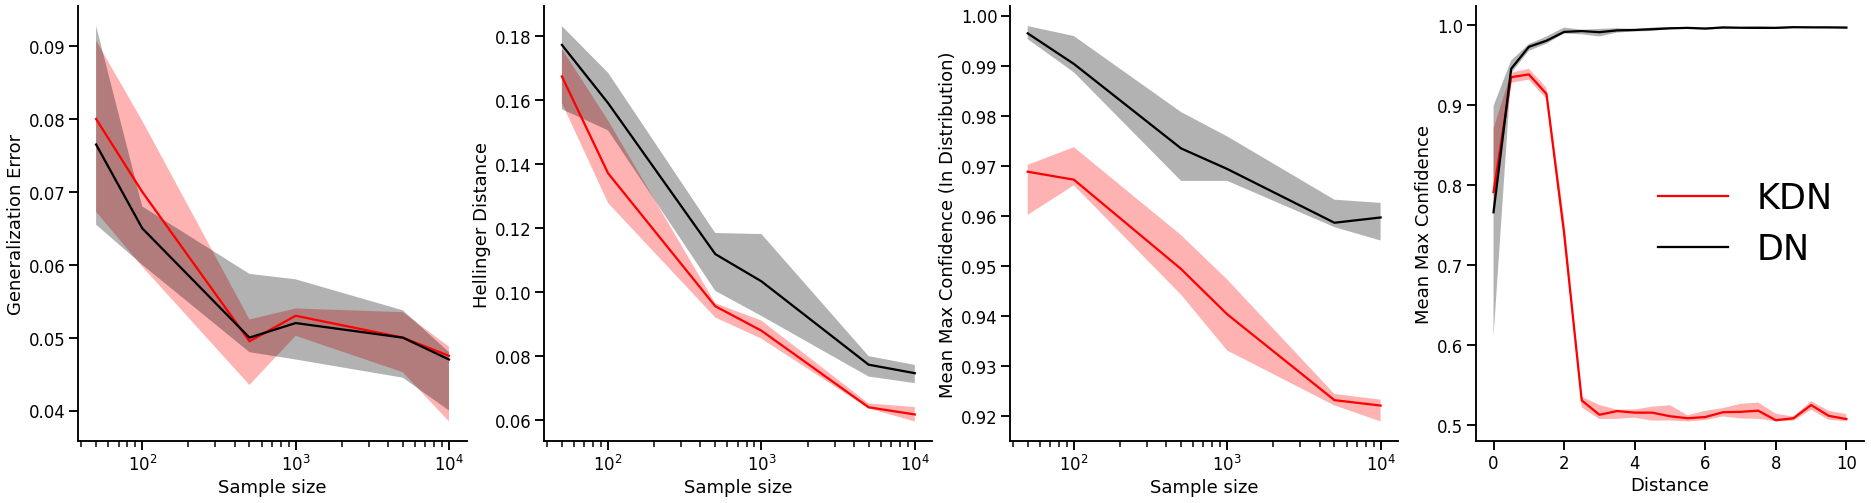


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB


systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



In [29]:
sample_size = [50, 100, 500, 1000, 5000, 10000]

sns.set_context('talk')
fig, ax = plt.subplots(1,4, figsize=(32,8))

ax[0].plot(sample_size, df['error_kdn_med'], c="r", label='KDN')
ax[0].plot(sample_size, df['error_dn_med'], c="k", label='DN')

ax[0].fill_between(sample_size, df['error_kdn_25'], df['error_kdn_75'], facecolor='r', alpha=.3)
ax[0].fill_between(sample_size, df['error_dn_25'], df['error_dn_75'], facecolor='k', alpha=.3)

ax[0].set_xscale('log')
ax[0].set_xlabel('Sample size')
ax[0].set_ylabel('Generalization Error')

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)




ax[1].plot(sample_size, df['hellinger_kdn_med'], c="r", label='KDN')
ax[1].plot(sample_size, df['hellinger_dn_med'], c="k", label='DN')

ax[1].fill_between(sample_size, df['hellinger_kdn_25'], df['hellinger_kdn_75'], facecolor='r', alpha=.3)
ax[1].fill_between(sample_size, df['hellinger_dn_25'], df['hellinger_dn_75'], facecolor='k', alpha=.3)

ax[1].set_xscale('log')
ax[1].set_xlabel('Sample size')
ax[1].set_ylabel('Hellinger Distance')

right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)




ax[2].plot(sample_size, df['mmcIn_kdn_med'], c="r", label='KDN')
ax[2].plot(sample_size, df['mmcIn_dn_med'], c="k", label='DN')

ax[2].fill_between(sample_size, df['mmcIn_kdn_25'], df['mmcIn_kdn_75'], facecolor='r', alpha=.3)
ax[2].fill_between(sample_size, df['mmcIn_dn_25'], df['mmcIn_dn_75'], facecolor='k', alpha=.3)

ax[2].set_xscale('log')
ax[2].set_xlabel('Sample size')
ax[2].set_ylabel('Mean Max Confidence (In Distribution)')

right_side = ax[2].spines["right"]
right_side.set_visible(False)
top_side = ax[2].spines["top"]
top_side.set_visible(False)


r = np.arange(0,10.5,.5)
ax[3].plot(r, df['mmcOut_kdn_med'], c="r", label='KDN')
ax[3].plot(r, df['mmcOut_dn_med'], c="k", label='DN')

ax[3].fill_between(r, df['mmcOut_kdn_25'], df['mmcOut_kdn_75'], facecolor='r', alpha=.3)
ax[3].fill_between(r, df['mmcOut_dn_25'], df['mmcOut_dn_75'], facecolor='k', alpha=.3)

#ax[3].set_xscale('log')
ax[3].set_xlabel('Distance')
ax[3].set_ylabel('Mean Max Confidence')

ax[3].legend(fontsize=35, frameon=False)

right_side = ax[3].spines["right"]
right_side.set_visible(False)
top_side = ax[3].spines["top"]
top_side.set_visible(False)

### OOD detection metrics

In [ ]:
def fpr_at_95_tpr(conf_t, conf_f):
    TPR = 95
    PERC = np.percentile(conf_t, 100-TPR)
    FP = np.sum(conf_f >=  PERC)
    FPR = np.sum(conf_f >=  PERC)/len(conf_f)
    return FPR, PERC

In [ ]:
sample = 10000
reps = 45
n_test = 1000
true_labels = np.hstack((np.ones(n_test, ), np.zeros(n_test, )))

roc_dn = []
roc_kdn = []

fpr_dn = []
fpr_kdn = []
reps_list = []

for ii in range(reps):
    X, y = generate_gaussian_parity(sample)
    X_test, y_test = generate_gaussian_parity(n_test)
    X_ood = generate_ood_samples(n_test)

    
    nn = getNN(input_size=2, num_classes=2)
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(k=.1, network=nn)
    model_kdn.fit(X, y)

    dn_in_conf = np.max(model_kdn.network.predict(X_test), axis=1)
    dn_out_conf = np.max(model_kdn.network.predict(X_ood), axis=1)
    dn_conf = np.hstack((dn_in_conf, dn_out_conf))
    roc_dn.append(
        roc_auc_score(true_labels, dn_conf)
    )
    fpr_dn.append(
        fpr_at_95_tpr(dn_in_conf, dn_out_conf)
    )
    
    

    kdn_in_conf = np.max(model_kdn.predict_proba(X_test), axis=1)
    kdn_out_conf = np.max(model_kdn.predict_proba(X_ood), axis=1)
    kdn_conf = np.hstack((kdn_in_conf, kdn_out_conf))
    roc_kdn.append(
        roc_auc_score(true_labels, kdn_conf)
    )
    fpr_kdn.append(
        fpr_at_95_tpr(kdn_in_conf, kdn_out_conf)
    )

    reps_list.append(ii)

In [ ]:
# obtain the AUROC and FPR@95 scores

# AUROC
print("KDN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_kdn), np.std(roc_kdn)))
print("DN AUROC = {:.3f} +/- {:.3f}".format(np.mean(roc_dn), np.std(roc_dn)))

In [61]:
# FPR@95
print("KDN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_kdn), np.std(fpr_kdn)))
print("DN FPR@95 = {:.3f} +/- {:.3f}".format(np.mean(fpr_dn), np.std(fpr_dn)))

KDN FPR@95 = 0.478 +/- 0.412
DN FPR@95 = 0.920 +/- 0.063
